In [ ]:
#Installing necessary libraries
!pip install tensorflow scikit-learn pandas matplotlib

### GRU


📈 Running GRU forecast for aspect: 'driver'


<ipython-input-5-8e3685e93569>:28: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_aspect['date'] = pd.to_datetime(df_aspect['at'], errors='coerce').dt.date
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


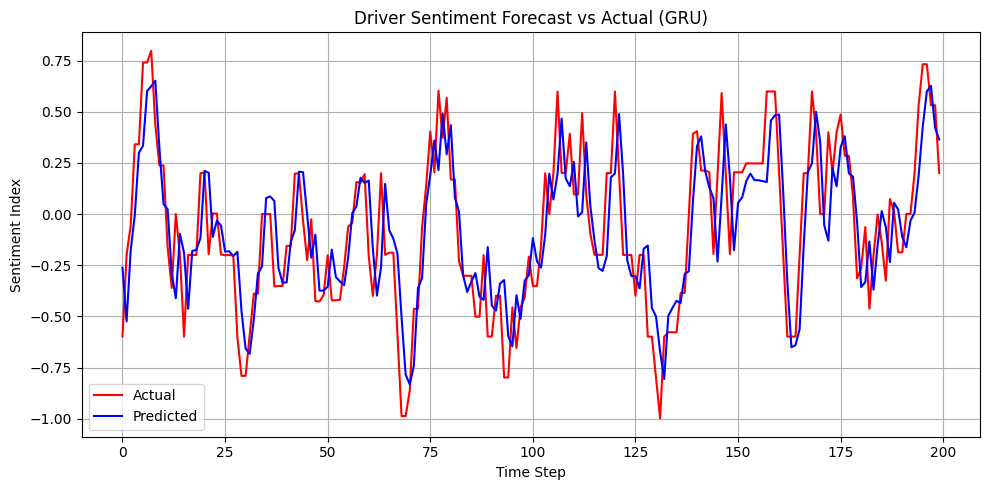

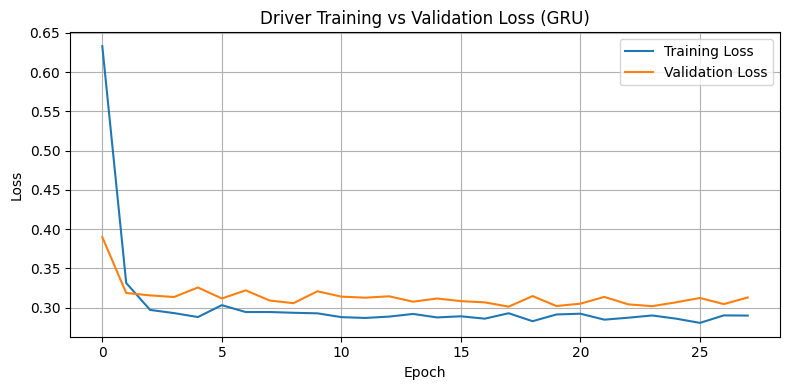


📈 Running GRU forecast for aspect: 'uber'


<ipython-input-5-8e3685e93569>:28: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_aspect['date'] = pd.to_datetime(df_aspect['at'], errors='coerce').dt.date
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


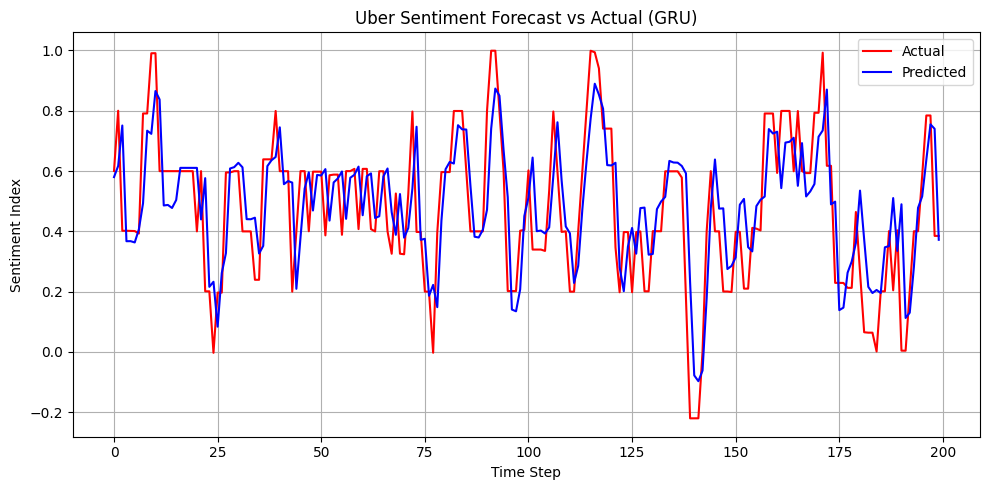

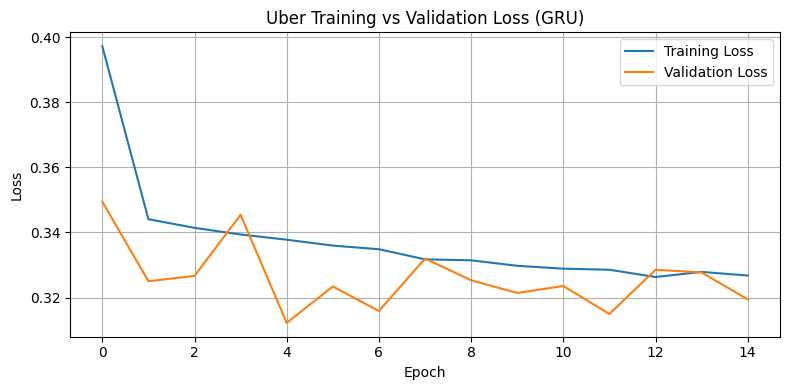


📈 Running GRU forecast for aspect: 'service'


<ipython-input-5-8e3685e93569>:28: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_aspect['date'] = pd.to_datetime(df_aspect['at'], errors='coerce').dt.date
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


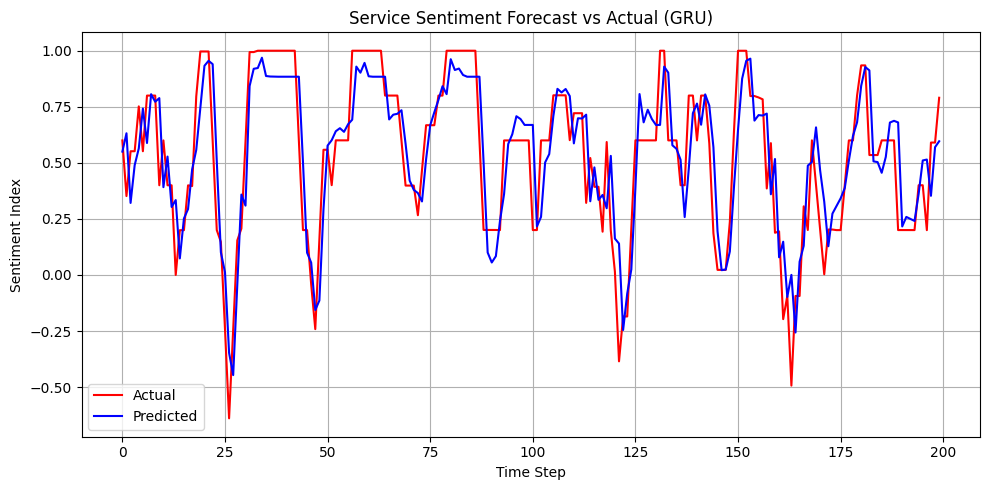

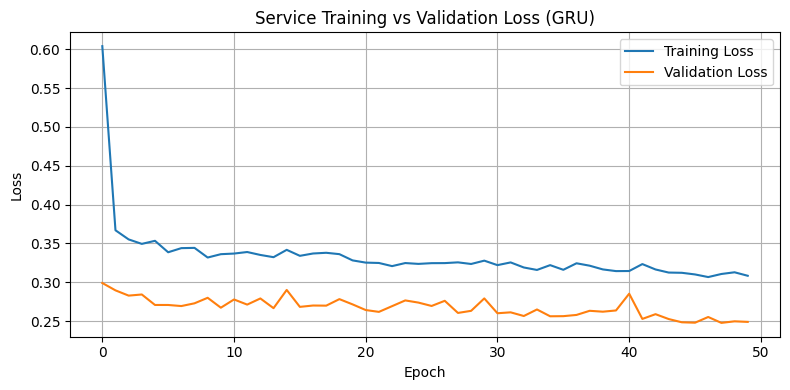


📈 Running GRU forecast for aspect: 'app'


<ipython-input-5-8e3685e93569>:28: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_aspect['date'] = pd.to_datetime(df_aspect['at'], errors='coerce').dt.date
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


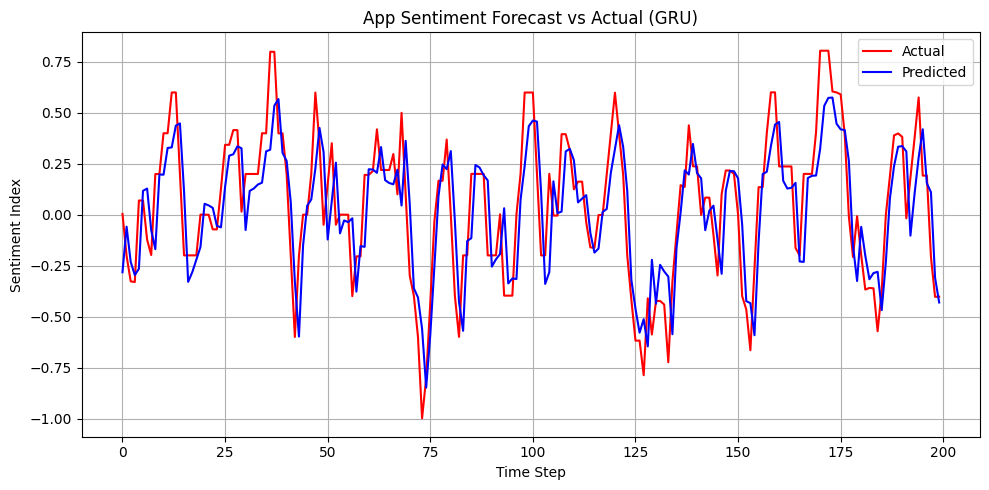

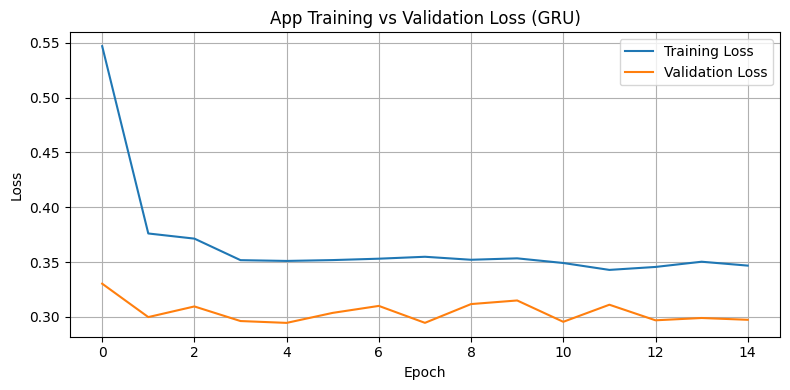


📊 Final Evaluation Results:


,MSE,RMSE,MAE,R2
driver,0.051504,0.226945,0.185507,0.653022
uber,0.026998,0.164311,0.130621,0.542824
service,0.032493,0.180257,0.142607,0.734411
app,0.044401,0.210717,0.171631,0.635452


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files



#Load dataset
df = pd.read_csv("/content/bert_extracted_with_sentiment_score.csv")


def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def forecast_sentiment_for_aspect_gru(df, aspect_name, seq_len=5, test_days=200, epochs=50):
    df['sentiment_index'] = df['positive_score'] - df['negative_score']
    df_aspect = df[df['predicted_aspects'].str.lower() == aspect_name.lower()].copy()
    df_aspect['date'] = pd.to_datetime(df_aspect['at'], errors='coerce').dt.date
    df_aspect = df_aspect[['date', 'sentiment_index']].dropna().sort_values('date').reset_index(drop=True)
    df_aspect['sentiment_index'] = df_aspect['sentiment_index'].rolling(window=5, min_periods=1).mean()

    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_aspect[['sentiment_index']])
    series = pd.Series(scaled.flatten(), index=df_aspect.index)

    X, y = create_sequences(series.values, seq_len)
    X_train, X_test = X[:-test_days], X[-test_days:]
    y_train, y_test = y[:-test_days], y[-test_days:]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = Sequential([
        GRU(128, return_sequences=True, input_shape=(seq_len, 1)),
        Dropout(0.3),
        GRU(64),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=0
    )

    preds = model.predict(X_test)
    preds_inv = scaler.inverse_transform(preds)
    y_true_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(10, 5))
    plt.plot(y_true_inv, label="Actual", color="red")
    plt.plot(preds_inv, label="Predicted", color="blue")
    plt.title(f"{aspect_name.capitalize()} Sentiment Forecast vs Actual (GRU)")
    plt.xlabel("Time Step")
    plt.ylabel("Sentiment Index")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label="Training Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.title(f"{aspect_name.capitalize()} Training vs Validation Loss (GRU)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_true_inv, preds_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_inv, preds_inv)
    r2 = r2_score(y_true_inv, preds_inv)

    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

#Run for each aspect
aspects_to_evaluate = ["driver", "uber", "service", "app"]
results = {}

for aspect in aspects_to_evaluate:
    print(f"\n📈 Running GRU forecast for aspect: '{aspect}'")
    results[aspect] = forecast_sentiment_for_aspect_gru(df.copy(), aspect)

#Displaying final evaluation table
gru_results_df = pd.DataFrame(results).T
print("\n📊 Final Evaluation Results:")
display(gru_results_df)


### RNN


📈 Running RNN forecast for aspect: 'driver'


<ipython-input-6-92c82a719e24>:26: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_aspect['date'] = pd.to_datetime(df_aspect['at'], errors='coerce').dt.date
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


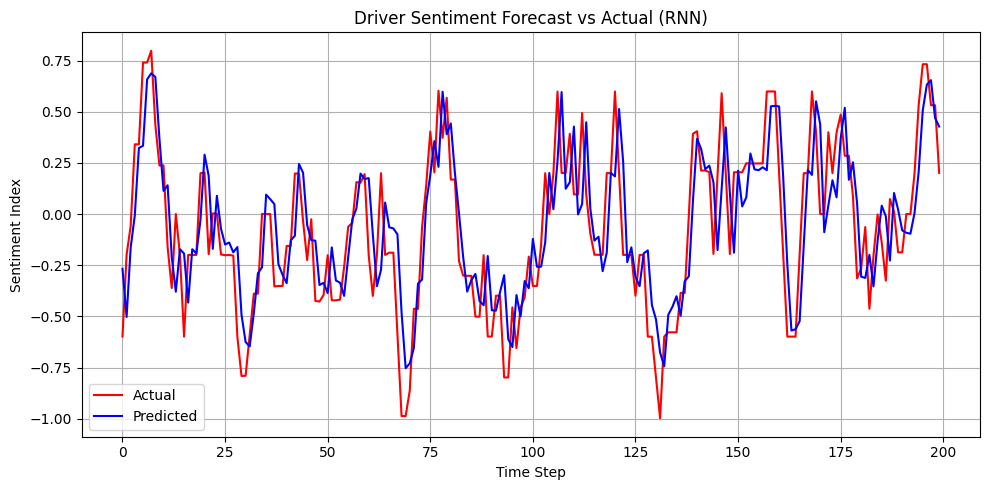

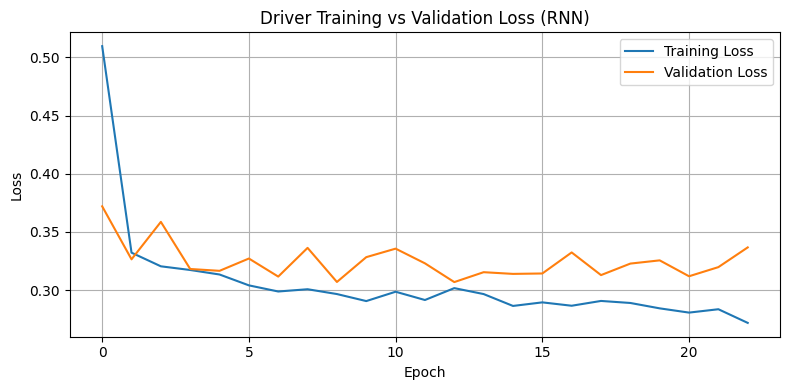


📈 Running RNN forecast for aspect: 'uber'


<ipython-input-6-92c82a719e24>:26: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_aspect['date'] = pd.to_datetime(df_aspect['at'], errors='coerce').dt.date
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


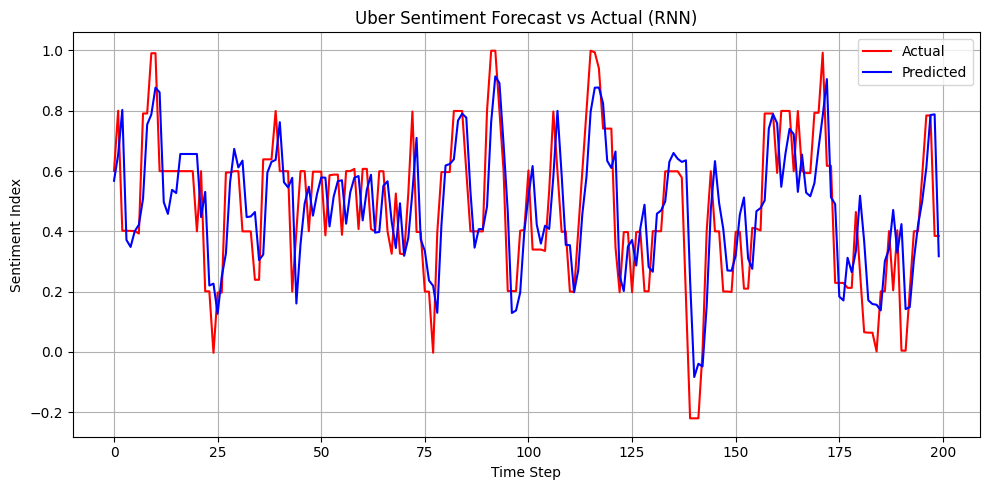

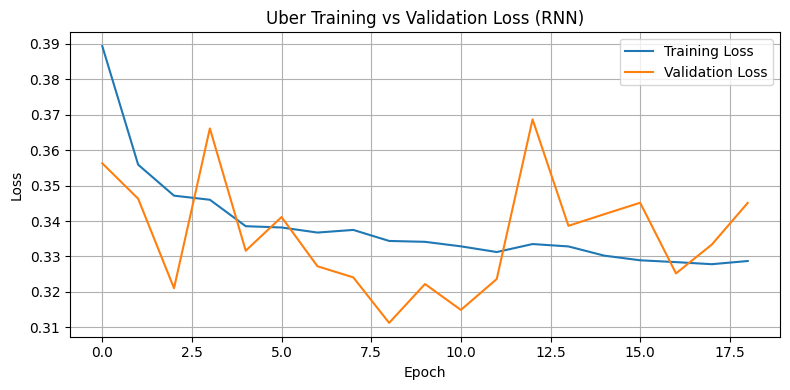


📈 Running RNN forecast for aspect: 'service'


<ipython-input-6-92c82a719e24>:26: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_aspect['date'] = pd.to_datetime(df_aspect['at'], errors='coerce').dt.date
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


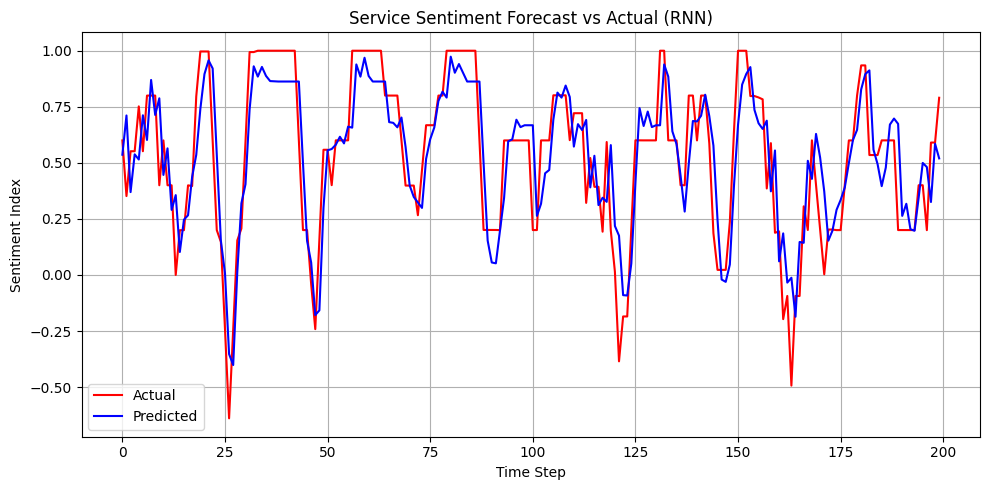

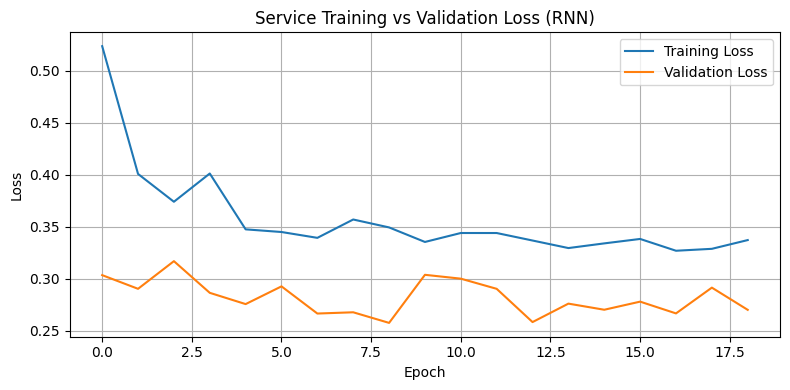


📈 Running RNN forecast for aspect: 'app'


<ipython-input-6-92c82a719e24>:26: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_aspect['date'] = pd.to_datetime(df_aspect['at'], errors='coerce').dt.date
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


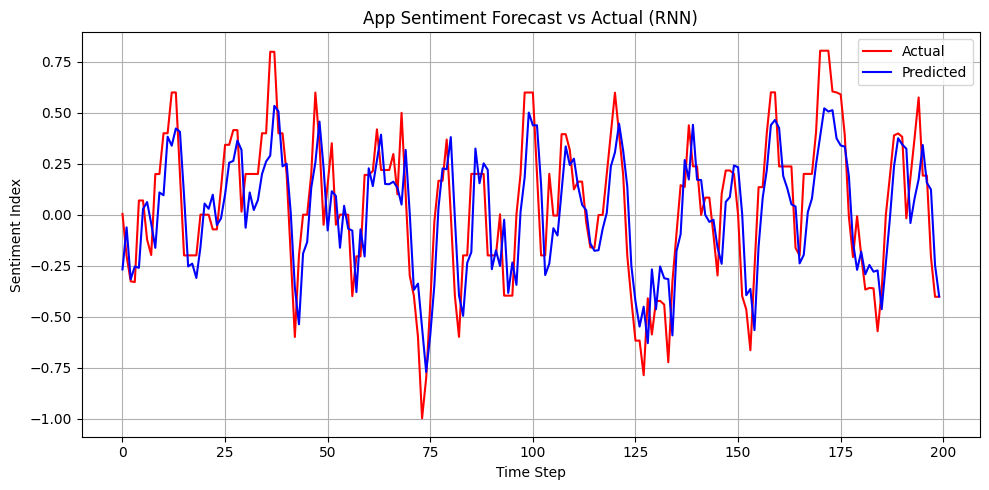

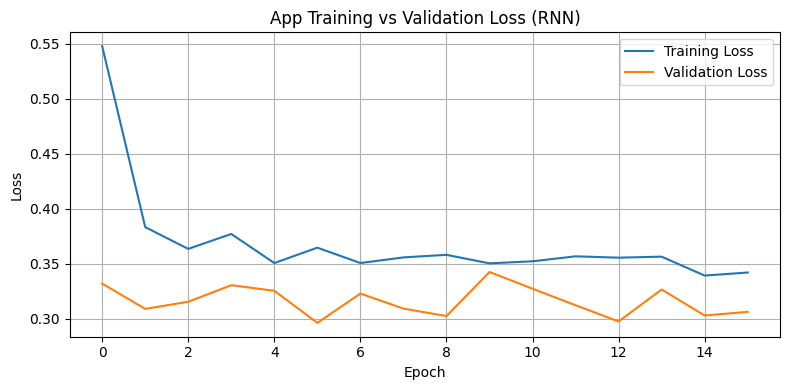


📊 Final Evaluation Results:


,MSE,RMSE,MAE,R2
driver,0.052478,0.229082,0.187838,0.646456
uber,0.026917,0.164064,0.131086,0.544200
service,0.033762,0.183746,0.145403,0.724032
app,0.044677,0.211370,0.176678,0.633187


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files


df = pd.read_csv("/content/bert_extracted_with_sentiment_score.csv")

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def forecast_sentiment_for_aspect_rnn(df, aspect_name, seq_len=5, test_days=200, epochs=50):
    df['sentiment_index'] = df['positive_score'] - df['negative_score']
    df_aspect = df[df['predicted_aspects'].str.lower() == aspect_name.lower()].copy()
    df_aspect['date'] = pd.to_datetime(df_aspect['at'], errors='coerce').dt.date
    df_aspect = df_aspect[['date', 'sentiment_index']].dropna().sort_values('date').reset_index(drop=True)
    df_aspect['sentiment_index'] = df_aspect['sentiment_index'].rolling(window=5, min_periods=1).mean()

    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_aspect[['sentiment_index']])
    series = pd.Series(scaled.flatten(), index=df_aspect.index)

    X, y = create_sequences(series.values, seq_len)
    X_train, X_test = X[:-test_days], X[-test_days:]
    y_train, y_test = y[:-test_days], y[-test_days:]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = Sequential([
        SimpleRNN(128, return_sequences=True, input_shape=(seq_len, 1)),
        Dropout(0.3),
        SimpleRNN(64),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=0
    )

    preds = model.predict(X_test)
    preds_inv = scaler.inverse_transform(preds)
    y_true_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(10, 5))
    plt.plot(y_true_inv, label="Actual", color="red")
    plt.plot(preds_inv, label="Predicted", color="blue")
    plt.title(f"{aspect_name.capitalize()} Sentiment Forecast vs Actual (RNN)")
    plt.xlabel("Time Step")
    plt.ylabel("Sentiment Index")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label="Training Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.title(f"{aspect_name.capitalize()} Training vs Validation Loss (RNN)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_true_inv, preds_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_inv, preds_inv)
    r2 = r2_score(y_true_inv, preds_inv)

    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

aspects_to_evaluate = ["driver", "uber", "service", "app"]
results = {}

for aspect in aspects_to_evaluate:
    print(f"\n📈 Running RNN forecast for aspect: '{aspect}'")
    results[aspect] = forecast_sentiment_for_aspect_rnn(df.copy(), aspect)

rnn_results_df = pd.DataFrame(results).T
print("\n📊 Final Evaluation Results:")
display(rnn_results_df)

### LSTM


📈 Running LSTM forecast for aspect: 'driver'


<ipython-input-7-911f10368126>:28: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_aspect['date'] = pd.to_datetime(df_aspect['at'], errors='coerce').dt.date
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


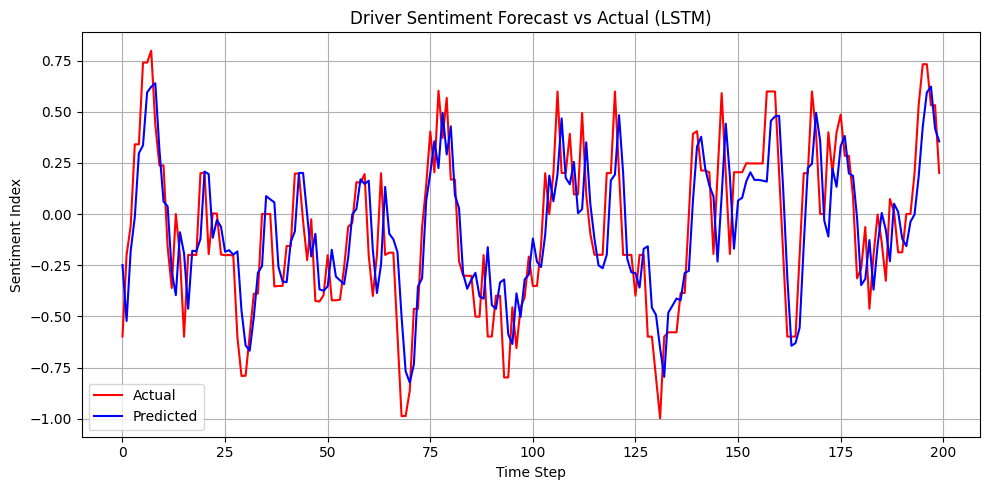

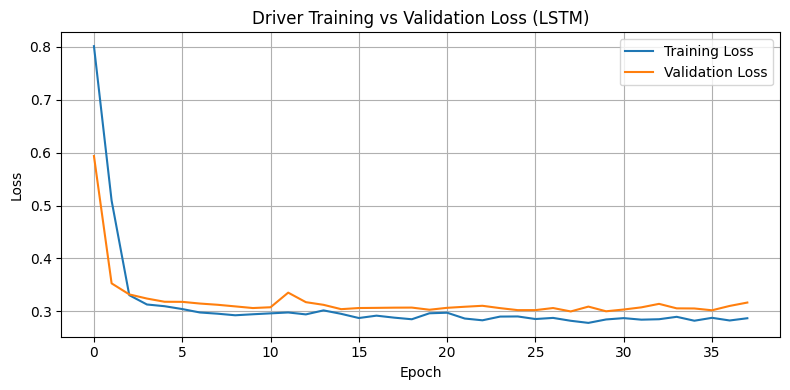


📈 Running LSTM forecast for aspect: 'uber'


<ipython-input-7-911f10368126>:28: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_aspect['date'] = pd.to_datetime(df_aspect['at'], errors='coerce').dt.date
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


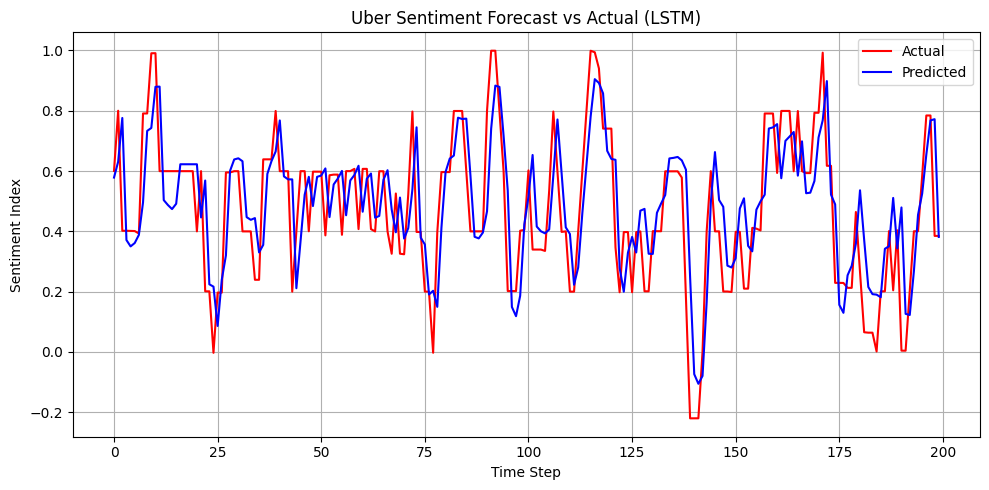

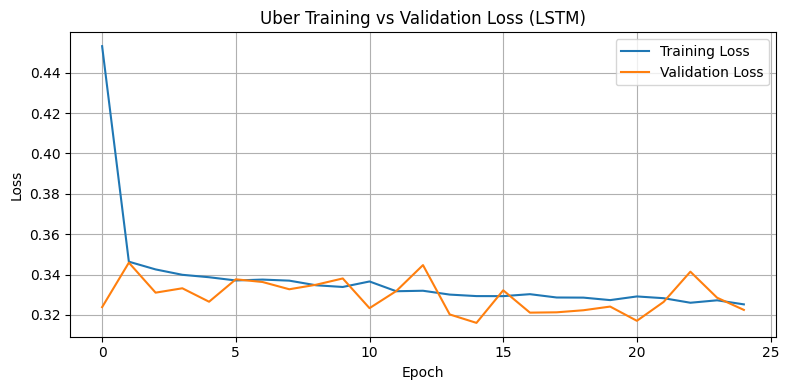


📈 Running LSTM forecast for aspect: 'service'


<ipython-input-7-911f10368126>:28: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_aspect['date'] = pd.to_datetime(df_aspect['at'], errors='coerce').dt.date
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


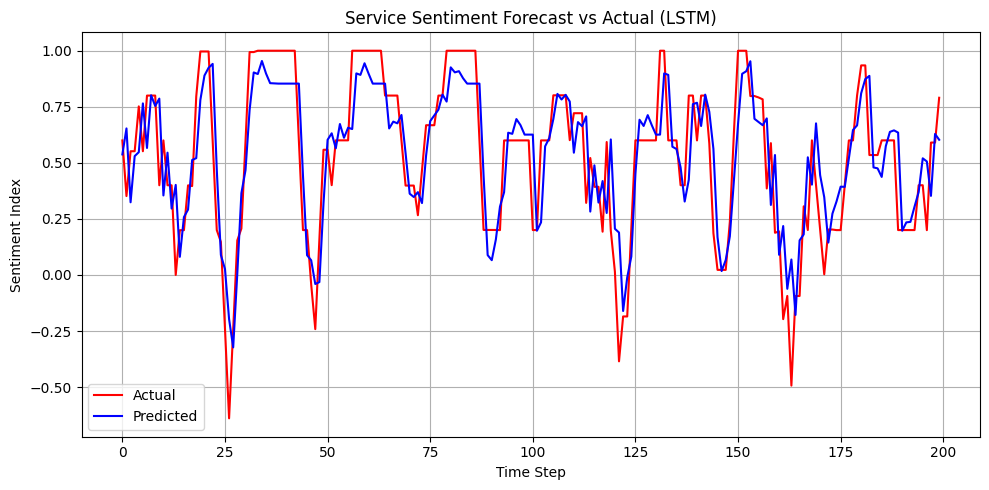

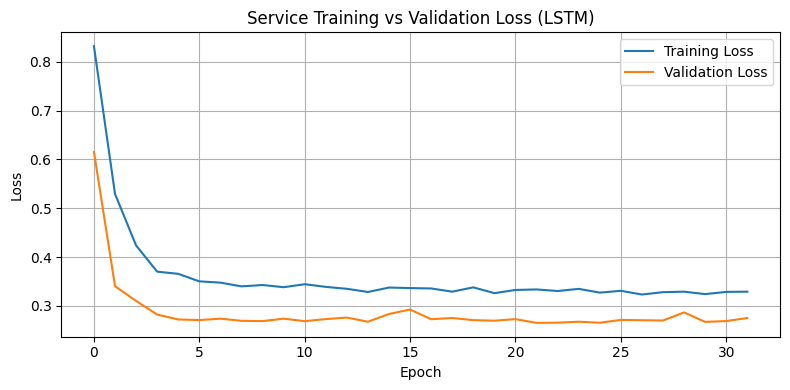


📈 Running LSTM forecast for aspect: 'app'


<ipython-input-7-911f10368126>:28: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_aspect['date'] = pd.to_datetime(df_aspect['at'], errors='coerce').dt.date
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


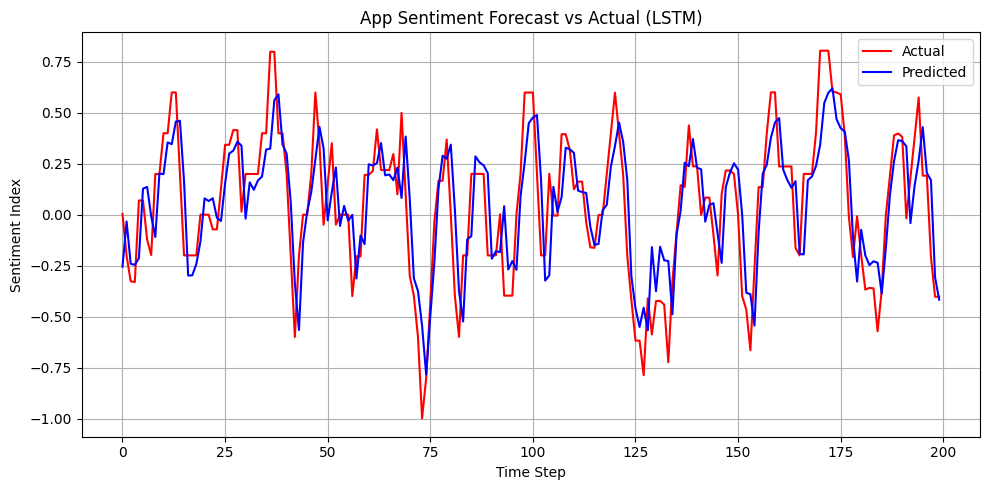

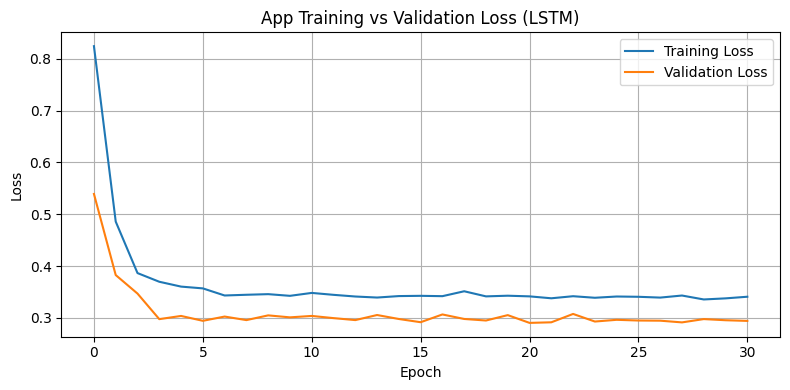


📊 Final Evaluation Results:


,MSE,RMSE,MAE,R2
driver,0.051281,0.226453,0.184777,0.654522
uber,0.027330,0.165317,0.131035,0.537209
service,0.034758,0.186434,0.146925,0.715899
app,0.043803,0.209292,0.168759,0.640366


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import files


df = pd.read_csv("/content/bert_extracted_with_sentiment_score.csv")

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def forecast_sentiment_for_aspect_lstm(df, aspect_name, seq_len=5, test_days=200, epochs=50):
    df['sentiment_index'] = df['positive_score'] - df['negative_score']
    df_aspect = df[df['predicted_aspects'].str.lower() == aspect_name.lower()].copy()
    df_aspect['date'] = pd.to_datetime(df_aspect['at'], errors='coerce').dt.date
    df_aspect = df_aspect[['date', 'sentiment_index']].dropna().sort_values('date').reset_index(drop=True)
    df_aspect['sentiment_index'] = df_aspect['sentiment_index'].rolling(window=5, min_periods=1).mean()

    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_aspect[['sentiment_index']])
    series = pd.Series(scaled.flatten(), index=df_aspect.index)

    X, y = create_sequences(series.values, seq_len)
    X_train, X_test = X[:-test_days], X[-test_days:]
    y_train, y_test = y[:-test_days], y[-test_days:]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(seq_len, 1)),
        Dropout(0.3),
        LSTM(64),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=0
    )

    preds = model.predict(X_test)
    preds_inv = scaler.inverse_transform(preds)
    y_true_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(10, 5))
    plt.plot(y_true_inv, label="Actual", color="red")
    plt.plot(preds_inv, label="Predicted", color="blue")
    plt.title(f"{aspect_name.capitalize()} Sentiment Forecast vs Actual (LSTM)")
    plt.xlabel("Time Step")
    plt.ylabel("Sentiment Index")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label="Training Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.title(f"{aspect_name.capitalize()} Training vs Validation Loss (LSTM)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_true_inv, preds_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_inv, preds_inv)
    r2 = r2_score(y_true_inv, preds_inv)

    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

aspects_to_evaluate = ["driver", "uber", "service", "app"]
results = {}

for aspect in aspects_to_evaluate:
    print(f"\n📈 Running LSTM forecast for aspect: '{aspect}'")
    results[aspect] = forecast_sentiment_for_aspect_lstm(df.copy(), aspect)

lstm_results_df = pd.DataFrame(results).T
print("\n📊 Final Evaluation Results:")
display(lstm_results_df)